# MC Dropout
## Implemented in PyTorch for a cubic polynomial/toy dataset

In [1]:
# NumPy for toy dataset generation
import numpy as np

# Matplotlib for plotting
import matplotlib.pyplot as plt
import matplotlib as mpl

# Import PyTorch
import torch

# Import math module
import math

# For properly copying model architectures to generate ensembles
import copy

# Setting figure quality
mpl.rcParams["figure.dpi"] = 300
plt.rcParams["figure.facecolor"] = "white"

## Defining a Custom Dataset Class, Data Generation Function, and Plotting Function

In [2]:
# PyTorch design philosophy asks for any training dataset to be loaded into a PyTorch "Dataset" class.
# We'll do this here. When the dataset class is written, it can be passed to a PyTorch DataLoader which
# controls how the data is fed to the model. We'll define a DataLoader later.
class Polynomial_Dataset(torch.utils.data.Dataset):
    def __init__(self, xLow, xHigh, numPoints, train=True):
        # Generate our polynomial dataset from our custom data generation function
        xData, yData = generate_data(xLow, xHigh, numPoints, train)
        # Convert to tensures, ensure float32 values
        self.xData = torch.as_tensor(xData.copy(), dtype=torch.float32).view(
            numPoints, 1
        )
        self.yData = torch.as_tensor(yData.copy(), dtype=torch.float32).view(
            numPoints, 1
        )

        # NumPy array versions of the data
        self.xDataNP = self.xData.numpy().copy().astype("float32")
        self.yDataNP = self.yData.numpy().copy().astype("float32")

        # Descriptive information about the dataset
        # Length
        self.length = numPoints
        # Theoretical lowest value
        self.xLow = xLow
        # Theoretical highest value
        self.xHigh = xHigh

    # The dataset needs to be iterable (i.e. accessible by an index or some custom enumeration)
    # So, we define a method for accessing the dataset here.
    def __getitem__(self, idx):
        # Get x-Value based on index
        xItem = self.xDataNP.item(idx)
        # Get y-Value baesd on index
        yItem = self.yDataNP.item(idx)

        # Return an ordered pair of points
        return (xItem, yItem)

    # Additionally, PyTorch DataLoader compatibility requires our dataset to have a length function.
    # Returns dataset # of samples
    def __len__(self):
        return self.length


# Function for generating the polynomial dataset
def generate_data(xLow, xHigh, numPoints, train=True):
    # Generate domain values
    x = np.linspace(xLow, xHigh, numPoints)
    # We want the dataset to be an xy array, so add an extra axis for y values via expand_dims
    # Additionally, ensure that values in the dataset are 32-bit floating point numbers.
    x = np.expand_dims(x, 1).astype(np.float32)

    # Establish standard deviation (i.e. uncertainty) for each datapoint.
    # Default to 3 standard deviations

    # If we are generating training data, then we will explicitly tell the model what the uncertainty is
    # because we are doing supervised learning.
    #  np.ones_like makes a constant array of 1's in the shape of x
    if train:
        sigma = 3 * np.ones_like(x)
    # Otherwise if we are generating test data, we want the model to guess uncertainty without
    # being explicitly told what the answer is.
    # np.zeroes_like makes a constant array of 0's in the shape of x
    else:
        sigma = 3 * np.zeros_like(x)

    # Generate the dataset using our x points. If it is training data, generate Gaussian uncertainty based
    # on how 'sigma' was defined. If it is test data, do not generate uncertainty values.
    y = x**3 + np.random.normal(0, sigma).astype(np.float32)

    return x, y


# Function for plotting predictions
def plot_predictions(
    xTrain, yTrain, xTest, yTest, yPred, yStd, numPoints, dropoutRate, nStds=4, kk=0
):
    # All the tensors are of shape [#Rows, 1]
    # Convert the tensors into shape [#Row] via torch.flatten such that they can be plotted without error.
    xTrain = torch.flatten(xTrain)
    yTrain = torch.flatten(yTrain)
    xTest = torch.flatten(xTest)
    yTest = torch.flatten(yTest)
    mu = torch.flatten(yPred)
    var = torch.flatten(yStd)
    var = np.minimum(var, 1e3)

    # Plotting Code
    plt.figure(figsize=(5, 3), dpi=200)
    plt.scatter(xTrain, yTrain, s=1.0, c="#463c3c", zorder=0, label="Train")
    plt.plot(xTest, yTest, "r--", zorder=2, label="True")
    plt.plot(xTest, mu, color="#007cab", zorder=3, label="Prediction")
    plt.plot([-4, -4], [-150, 150], "k--", alpha=0.4, zorder=0)
    plt.plot([+4, +4], [-150, 150], "k--", alpha=0.4, zorder=0)

    # Shade the area of uncertainty associated with the toy dataset
    for k in np.linspace(0, nStds, 4):
        plt.fill_between(
            xTest,
            (mu - k * var),
            (mu + k * var),
            alpha=0.3,
            edgecolor=None,
            facecolor="#00aeef",
            linewidth=0,
            zorder=1,
            label="Uncertainty" if k == 0 else None,
        )

    plt.gca().set_ylim(-150, 150)
    plt.gca().set_xlim(-7, 7)
    plt.legend(loc="upper left")
    plt.title(
        "MC Dropout\n("
        + str(numPoints)
        + " Samples, "
        + str(dropoutRate)
        + " Dropout Rate)"
    )
    plt.show()

## Defining a Custom Dataset Class, Data Generation Function, and Plotting Function

In [3]:
# Creating the PyTorch Model Class for the ANN.
# To implement MC dropout, we need to:
# (1) Add dropout layers to the model architecture
# (2) Train with these dropout layers activated
# (3) Activate these layers post-training to generate prediction sets
# (4) Average and compute a std. dev. on the prediction sets to get a mean prediction
#     and associated uncertainty.


class ANN(torch.nn.Module):
    def __init__(self, numInputs=64, numOutputs=64, dropoutRate=0.05):
        super(ANN, self).__init__()

        # Add dropout layers in between the fully connected, linear layers.
        # The fraction of nodes dropped out in each layer is specified with dropoutRate
        self.linear1 = torch.nn.Linear(numInputs, numOutputs)
        self.activation1 = torch.nn.ReLU()
        self.dropout1 = torch.nn.Dropout(p=dropoutRate, inplace=False)
        self.linear2 = torch.nn.Linear(numOutputs, numOutputs)
        self.dropout2 = torch.nn.Dropout(p=dropoutRate, inplace=False)
        self.activation2 = torch.nn.ReLU()
        self.linear3 = torch.nn.Linear(numOutputs, 1)
        self.dropout3 = torch.nn.Dropout(p=dropoutRate, inplace=False)

    # Define forward passing of the neural network
    def forward(self, x):
        x = self.linear1(x)
        x = self.activation1(x)
        x = self.dropout1(x)
        x = self.linear2(x)
        x = self.activation2(x)
        x = self.dropout2(x)
        x = self.linear3(x)
        x = self.dropout3(x)

        return x

## Defining a Custom Evidential Loss Function

In [4]:
def MAE(y, yPred, reduce=True):
    # Get the predictive error
    error = torch.abs(y - yPred)

    return torch.mean(error) if reduce else error

## Generate Training/Test Data

In [12]:
# Set a global NumPy seed for random number generation, improves reproducibility.
np.random.seed(0)
# Set a global PyTorch seed for random number generation, improves reproducibility.
torch.manual_seed(0)

# Number of samples desired to calculate predictive mean and standard deviation (i.e., uncertainty)
numPoints = 10000

# Generate data
trainingData = Polynomial_Dataset(-4, 4, 1000, train=True)

testData = Polynomial_Dataset(-7, 7, 1000, train=False)

## Define a Dataloader for Feeding Data to Model

In [6]:
# Specify a batch size to load into the model for mini-batch optimization.
trainBatchSize = 100
# Specify a batch size to load into the model for making test predictions.
evalBatchSize = 1000

# PyTorch design philosophy uses "DataLoader" objects to feed the data to the ML model during training and inference
# One defines a DataLoader and then passes the data to it.

trainDL = torch.utils.data.DataLoader(
    trainingData, batch_size=trainBatchSize, shuffle=False
)

testDL = torch.utils.data.DataLoader(testData, batch_size=evalBatchSize, shuffle=False)

## Instantiate the Model Before Training

In [7]:
# Define a dropout rate for MC dropout (fraction of nodes dropped out per layer)
dropoutRate = 0.05

# Instantiate the model and print the model architecture.
myModel = ANN(numInputs=1, dropoutRate=dropoutRate)

# Cast all model parameters to 64-bit floating point numbers
# All the numbers have the be the same datatype (i.e. 64-bit) for PyTorch to accept the data
myModel = myModel.double()

## Instantiate an Optimizer Before Training

In [8]:
# Create an optimizer
optimizer = torch.optim.Adam(myModel.parameters(), lr=5e-4, eps=1e-07)

## Train the model

In [9]:
# Number of epochs to train for.
numEpoch = 500

for epoch in range(numEpoch):
    lossCounter = 0.0

    # Get the data
    for batchIndex, batchData in enumerate(trainDL):
        xData = batchData[0]
        xData = xData.view(trainBatchSize, 1)
        yData = batchData[1]
        yData = yData.view(trainBatchSize, 1)

        # Zero the parameter gradients between each epoch (because we start fresh with the training each epoch)
        myModel.zero_grad()

        # Forward passing
        outputs = myModel(xData)
        # Calculating loss
        loss = MAE(yData, outputs)
        # Backwards passing, automatically performed
        loss.backward()
        # Continue with optimization
        optimizer.step()

        # Statistics to show training
        lossCounter += loss.item()
        # Every 10 mini-batches and 5 epochs, print
        if (batchIndex % 10 == 9) and (epoch % 5 == 4):
            print(
                "[%d, %5d] loss: %.3f" % (epoch + 1, batchIndex + 1, lossCounter / 10)
            )
            epochLoss = lossCounter
            # Reset the loss counter for the next set of mini-batches
            lossCounter = 0.0

print("\nTraining Complete.\n")

# Final training statistics
print("Final loss: %.3f" % (epochLoss / 10))

[5,    10] loss: 16.018
[10,    10] loss: 14.800
[15,    10] loss: 13.056
[20,    10] loss: 11.273
[25,    10] loss: 9.973
[30,    10] loss: 9.002
[35,    10] loss: 8.635
[40,    10] loss: 8.577
[45,    10] loss: 8.164
[50,    10] loss: 7.948
[55,    10] loss: 7.893
[60,    10] loss: 7.617
[65,    10] loss: 7.570
[70,    10] loss: 7.626
[75,    10] loss: 7.255
[80,    10] loss: 7.358
[85,    10] loss: 7.040
[90,    10] loss: 6.673
[95,    10] loss: 6.863
[100,    10] loss: 6.909
[105,    10] loss: 6.401
[110,    10] loss: 6.294
[115,    10] loss: 6.368
[120,    10] loss: 6.574
[125,    10] loss: 6.153
[130,    10] loss: 6.043
[135,    10] loss: 5.836
[140,    10] loss: 6.003
[145,    10] loss: 6.060
[150,    10] loss: 5.562
[155,    10] loss: 5.830
[160,    10] loss: 5.589
[165,    10] loss: 5.368
[170,    10] loss: 5.519
[175,    10] loss: 5.508
[180,    10] loss: 5.381
[185,    10] loss: 5.338
[190,    10] loss: 5.276
[195,    10] loss: 5.405
[200,    10] loss: 5.360
[205,    10] los

## Make Predictions with the Model

In [13]:
# The model is now trained, so let's make some predictions on the test dataset.

# Disable the autograd engine, as we only need gradients in our model during training.
# Disabling this improves inference speed

# Store predictions for each dropout
# The idea is that each dropout trial's predictions can be averaged together to get a mean prediction.
# Standard deviation can be calculated to get the uncertainty of each prediction.

dropoutPredictions = []

for dropoutIter in range(numPoints):
    with torch.no_grad():
        # Set the model into training mode.
        # This ensures that dropout layers are activated and working when making test predictions.
        myModel.train()

        # Get the data
        for batchIndex, batchData in enumerate(testDL):
            xData = batchData[0]
            xData = xData.view(evalBatchSize, 1)

            # Make Predictions
            outputs = myModel(xData)

            # Take each mini-batch prediction set and combine them via concatenation to get the total prediction set.
            if batchIndex != 0:
                # Make Predictions
                outputs = myModel(xData)
                outputs = torch.cat((previousOutputs, outputs), dim=0)
                previousOutputs = outputs
            else:
                previousOutputs = myModel(xData)

    dropoutPredictions.append(outputs)

## Plot Prediction Trendline with the Real Data and Real Trendline

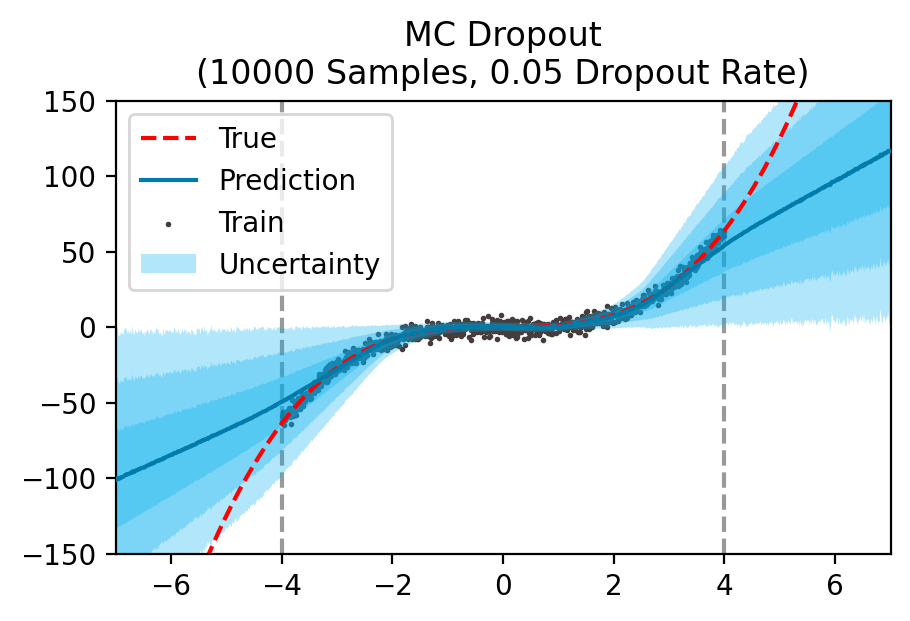

In [14]:
# Average the prediction sets together to get an average prediction trendline
predMean = torch.mean(torch.stack(dropoutPredictions, dim=0), dim=0)
# Compute standard deviation of each prediction in the averaged prediction set.
predStd = torch.std(torch.stack(dropoutPredictions, dim=0), dim=0)
fullTrainingData = torch.Tensor(trainingData)

xTrain = fullTrainingData[:, 0]
yTrain = fullTrainingData[:, 1]
xTest = testData.xData
yTest = testData.yData

plot_predictions(
    xTrain, yTrain, xTest, yTest, predMean, predStd, numPoints, dropoutRate
)